In [ ]:
%pip install tensorflow-addons
%pip show tensorflow

# Import package and module

In [5]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

In [6]:
print(tf.__version__)

2.8.0


In [7]:
tf.config.list_physical_devices("GPU")
!nvidia-smi

Mon May  9 16:03:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:29:00.0  On |                  N/A |
|  0%   47C    P8    19W / 125W |    629MiB /  6144MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13647741031592506201
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4189650944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10100021635316756747
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:29:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Load path

In [9]:
from imutils import paths
train_dir = './cigarette-smoker-detection-kaggle/train'
test_dir = './cigarette-smoker-detection-kaggle/test'

# Preprocessing

### Preprocessing

In [10]:
img_size = 224
batch_size = 32
seed = 72
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    label_mode="binary",
    image_size=(img_size,img_size),
    batch_size=batch_size
)

Found 3185 files belonging to 2 classes.
Using 2548 files for training.
Found 3185 files belonging to 2 classes.
Using 637 files for validation.


In [11]:
train_ds.class_names

['not_smoking', 'smoking']

Sample data

In [ ]:
for image_batch, labels_batch in train_ds:
  #print(image_batch.shape)
  print(labels_batch)
  break

## Rescale

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Rescale result

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch[1])
  print(labels_batch[1])
  break

tf.Tensor(
[[[0.3429372  0.35078034 0.33901563]
  [0.28475392 0.29259706 0.28083235]
  [0.29013607 0.29013607 0.28229293]
  ...
  [0.20331047 0.20331047 0.17193793]
  [0.18022585 0.18022585 0.1488533 ]
  [0.22941396 0.21764925 0.19019827]]

 [[0.34663868 0.35448182 0.35056025]
  [0.3446177  0.36030397 0.3563824 ]
  [0.33745503 0.3531413  0.34921974]
  ...
  [0.20478214 0.19301744 0.16556646]
  [0.19280027 0.18103556 0.15358458]
  [0.2345862  0.22282149 0.19537051]]

 [[0.34873945 0.35658258 0.352661  ]
  [0.347679   0.35552213 0.35160056]
  [0.34453782 0.35238096 0.34061626]
  ...
  [0.24636023 0.22675239 0.20322296]
  [0.19987798 0.18027012 0.15674071]
  [0.25313812 0.23353028 0.21000087]]

 ...

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  ...
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0

# Train

In [13]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(img_size, img_size, 3),
    weights="imagenet",
    include_preprocessing=False,
    include_top=False,
    pooling="avg"
)

base_model.trainable = False

In [14]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(units=1, activation = "sigmoid")
])

In [15]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

Model Summary

In [16]:
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Start train

In [ ]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

Epoch 1/150
80/80 [==============================] - 74s 820ms/step - loss: 0.5888 - accuracy: 0.7206 - precision: 0.7421 - recall: 0.8300 - val_loss: 0.4190 - val_accuracy: 0.8085 - val_precision: 0.8301 - val_recall: 0.8719
Epoch 2/150
80/80 [==============================] - 48s 585ms/step - loss: 0.4278 - accuracy: 0.8140 - precision: 0.8232 - recall: 0.8847 - val_loss: 0.3721 - val_accuracy: 0.8336 - val_precision: 0.8333 - val_recall: 0.9171
Epoch 3/150
80/80 [==============================] - 48s 581ms/step - loss: 0.3897 - accuracy: 0.8356 - precision: 0.8416 - recall: 0.8995 - val_loss: 0.3592 - val_accuracy: 0.8320 - val_precision: 0.8684 - val_recall: 0.8618
Epoch 4/150
80/80 [==============================] - 49s 594ms/step - loss: 0.3614 - accuracy: 0.8465 - precision: 0.8521 - recall: 0.9053 - val_loss: 0.3427 - val_accuracy: 0.8446 - val_precision: 0.8691 - val_recall: 0.8844
Epoch 5/150
80/80 [==============================] - 48s 581ms/step - loss: 0.3466 - accuracy: 0

Result #1 train

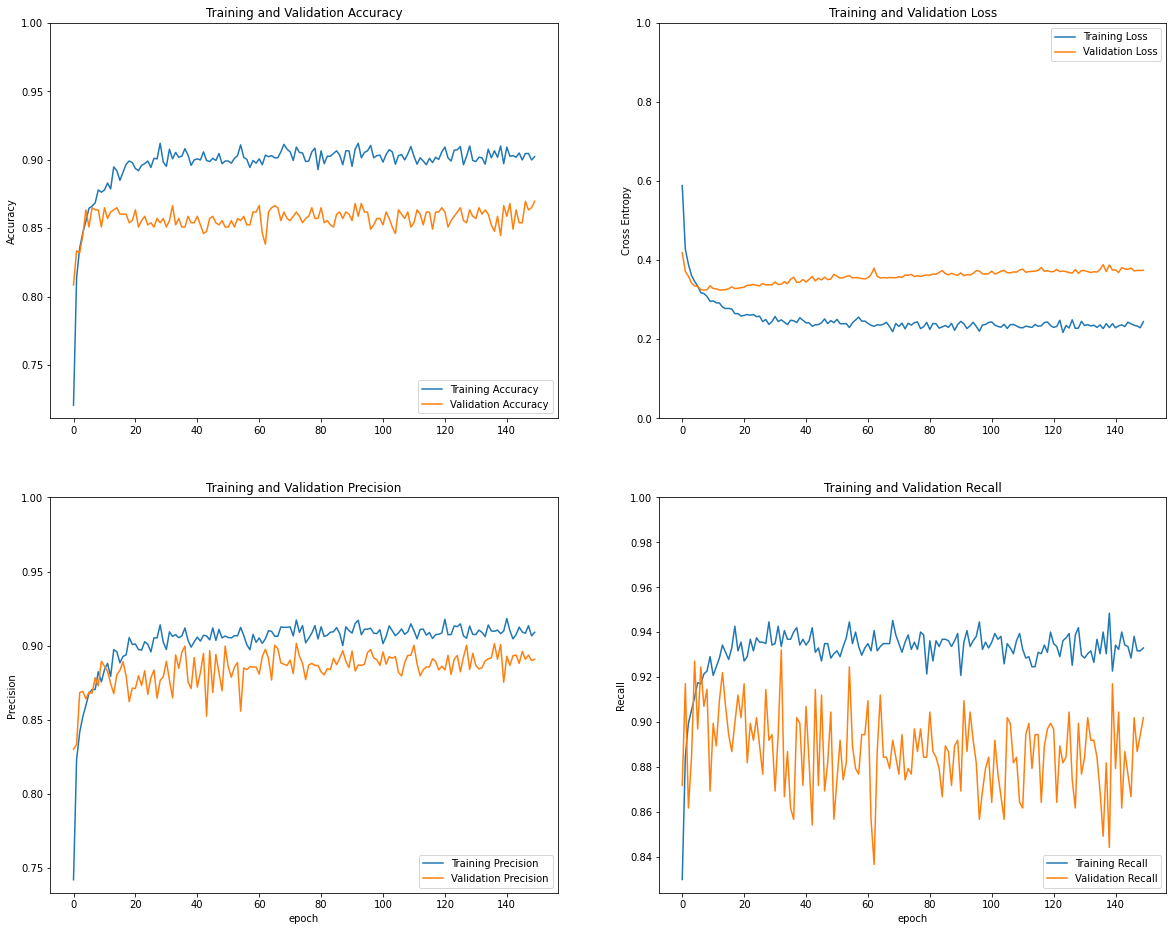

In [ ]:
acc = history_1.history['accuracy']
prec = history_1.history['precision']
recall = history_1.history['recall']
loss = history_1.history['loss']

val_acc = history_1.history['val_accuracy']
val_prec = history_1.history['val_precision']
val_recall = history_1.history['val_recall']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()

# Saving and Load the model

In [ ]:
save_path = './Developed-model'
model.save(save_path)

INFO:tensorflow:Assets written to: ./Developed-model\assets


INFO:tensorflow:Assets written to: ./Developed-model\assets


Load model experiment 1

In [7]:
history_1 = tf.keras.models.load_model('Developed-model/exp1')
history_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 961
Non-trainable params: 2,996,352
_________________________________________________________________


# Evaulate exp 1 with test data

Making the test set

In [22]:
img_size = 224
batch_size = 32
seed = 72

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    label_mode="binary",
    image_size=(img_size, img_size),
    batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 90 files belonging to 2 classes.


In [14]:
history_1.evaluate(test_ds)

3/3 [==============================] - 1s 397ms/step - loss: 0.8472 - accuracy: 0.6556 - precision: 0.5921 - recall: 1.0000


[0.8472484946250916, 0.6555555462837219, 0.5921052694320679, 1.0]

# Fine tune 1

In [11]:
history_1.trainable = True

history_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 960)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,997,313
Trainable params: 2,972,913
Non-trainable params: 24,400
_________________________________________________________________


In [15]:
history_1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()
                       #,tfa.metrics.F1Score(num_classes= 2 )
                       ])

In [16]:
history_2 = history_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    steps_per_epoch=len(train_ds),
    validation_steps=len(val_ds)
)

Epoch 1/300
80/80 [==============================] - 154s 2s/step - loss: 0.1117 - accuracy: 0.9557 - precision_1: 0.9645 - recall_1: 0.9627 - val_loss: 46.4838 - val_accuracy: 0.7708 - val_precision_1: 0.7461 - val_recall_1: 0.9598
Epoch 2/300
80/80 [==============================] - 144s 2s/step - loss: 0.0720 - accuracy: 0.9768 - precision_1: 0.9819 - recall_1: 0.9800 - val_loss: 15.7199 - val_accuracy: 0.7457 - val_precision_1: 0.8260 - val_recall_1: 0.7513
Epoch 3/300
80/80 [==============================] - 144s 2s/step - loss: 0.0473 - accuracy: 0.9847 - precision_1: 0.9878 - recall_1: 0.9871 - val_loss: 5.7566 - val_accuracy: 0.7661 - val_precision_1: 0.8105 - val_recall_1: 0.8166
Epoch 4/300
80/80 [==============================] - 144s 2s/step - loss: 0.1030 - accuracy: 0.9686 - precision_1: 0.9792 - recall_1: 0.9691 - val_loss: 1795.2638 - val_accuracy: 0.3752 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/300
80/80 [==============================] - 143s 2

Fine tune 1 result

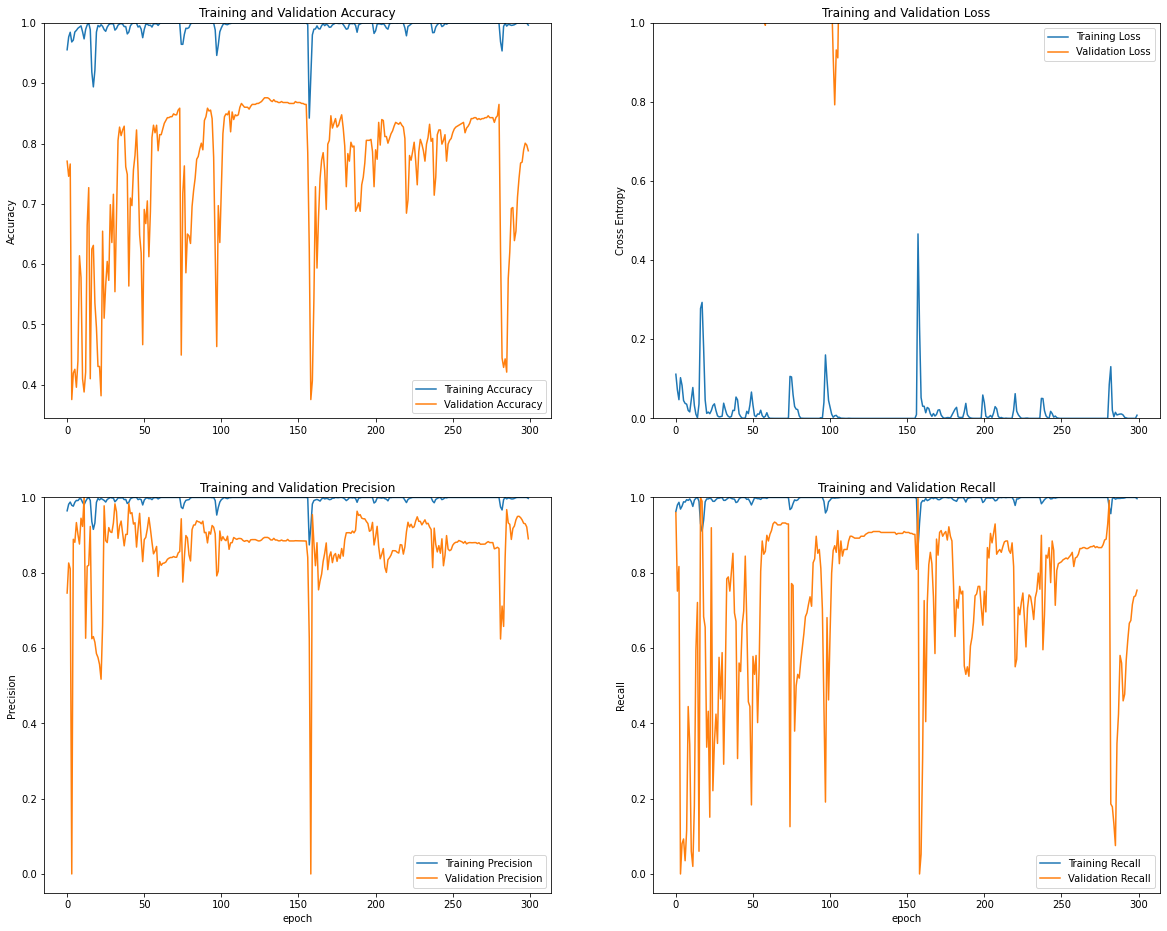

In [18]:
acc = history_2.history['accuracy']
prec = history_2.history['precision_1']
recall = history_2.history['recall_1']
loss = history_2.history['loss']

val_acc = history_2.history['val_accuracy']
val_prec = history_2.history['val_precision_1']
val_recall = history_2.history['val_recall_1']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(20, 16))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(prec, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')

plt.xlabel('epoch')
plt.show()

In [21]:
save_path = './Developed-model/exp2'
history_1.save(save_path)

INFO:tensorflow:Assets written to: ./Developed-model/exp2\assets


INFO:tensorflow:Assets written to: ./Developed-model/exp2\assets


# Evaluate Fine tune 1 with test data

In [24]:
history_1.evaluate(test_ds)

3/3 [==============================] - 2s 431ms/step - loss: 2.7342 - accuracy: 0.6889 - precision_1: 0.6308 - recall_1: 0.9111


[2.7341854572296143,
 0.6888889074325562,
 0.6307692527770996,
 0.9111111164093018]

# Export Fine tune 1 metrics result to csv

In [25]:
fine_tune_1_result = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
import csv
from itertools import zip_longest

data = [acc, prec, recall, loss, val_acc, val_prec, val_recall, val_loss]
export_data = zip_longest(*data, fillvalue = '')

with open('fine_tune_1_result.csv', 'w', encoding="ISO-8859-1", newline='') as file:
      write = csv.writer(file)
      write.writerow(("acc", "prec", "recall", "loss", "val_acc", "val_prec", "val_recall", "val_loss"))
      write.writerows(export_data)